## Robot Intelligence 6: Coding Up Bayes Rule with Chains, 1-D Kalman Filtering

In mobile robot localization, our goal is to estimate the position of our robot in the environment as accurately as possible from (possibly noisy) sensor readings.

As we saw during lecture, a powerful tool for accomplishing this task is known as *the Bayes Filter*.

## Discrete Bayes Filter Algorithm

The *Bayes Filter* is a general algorithm for computing *belief* from observations and control data in an iterative fashion.

More concretely, given some perceptual data $z$ and a set of candidate robot positions $\mathcal{X}$, the discrete Bayes Filter iterates over all candidate position $x \in \mathcal{X}$, updates the *belief* $Bel'(x)$ (or, *estimated probability*) that the robot is indeed at $x$ by computing the product between:

* **the probability of the given perceptual measurement $z$ given that the robot is at $x$**, $\mathbb{P}(z | x)$; and
* **the current *belief* $Bel(x)$ that the robot is at $x$** (i.e. the probability that the robot is at $x$ given all previously processed measurements)


Then, once beliefs for all candidate positions have been updated to reflect the perceptual data $z$, the full set of beliefs $\{Bel'(x) \ | \ x \in \mathcal{X}\}$ is *re-normalized* to sum to $1$, so that it reflects a valid probability distribution over all possible robot states $\mathcal{X}$.

If, on the other hand, the source of our localization data is the **robot controller**, i.e. instead of *perceptual* data of the robot's direct position we have indirect *action* data $u$, then for each candidate robot position $x \in \mathcal{X}$, we update our belief $Bel'(x)$ to the **sum over all products between**

* **the probability that the robot ended up at $x$ by applying the control action $u$ at some other position $x'$**, $\mathbb{P}(x \ | \ u, x')$; and
* **the current belief $Bel(x')$ that the robot was at $x'$**

for all $x' \in \mathcal{X}$.

Then, as before, we re-normalize the updated set of beliefs $\{Bel'(x) \ | \ x \in \mathcal{X}\}$ to yield a valid probability distribution over $\mathcal{X}$.

The full discrete Bayes Filter algorithm is written out below.

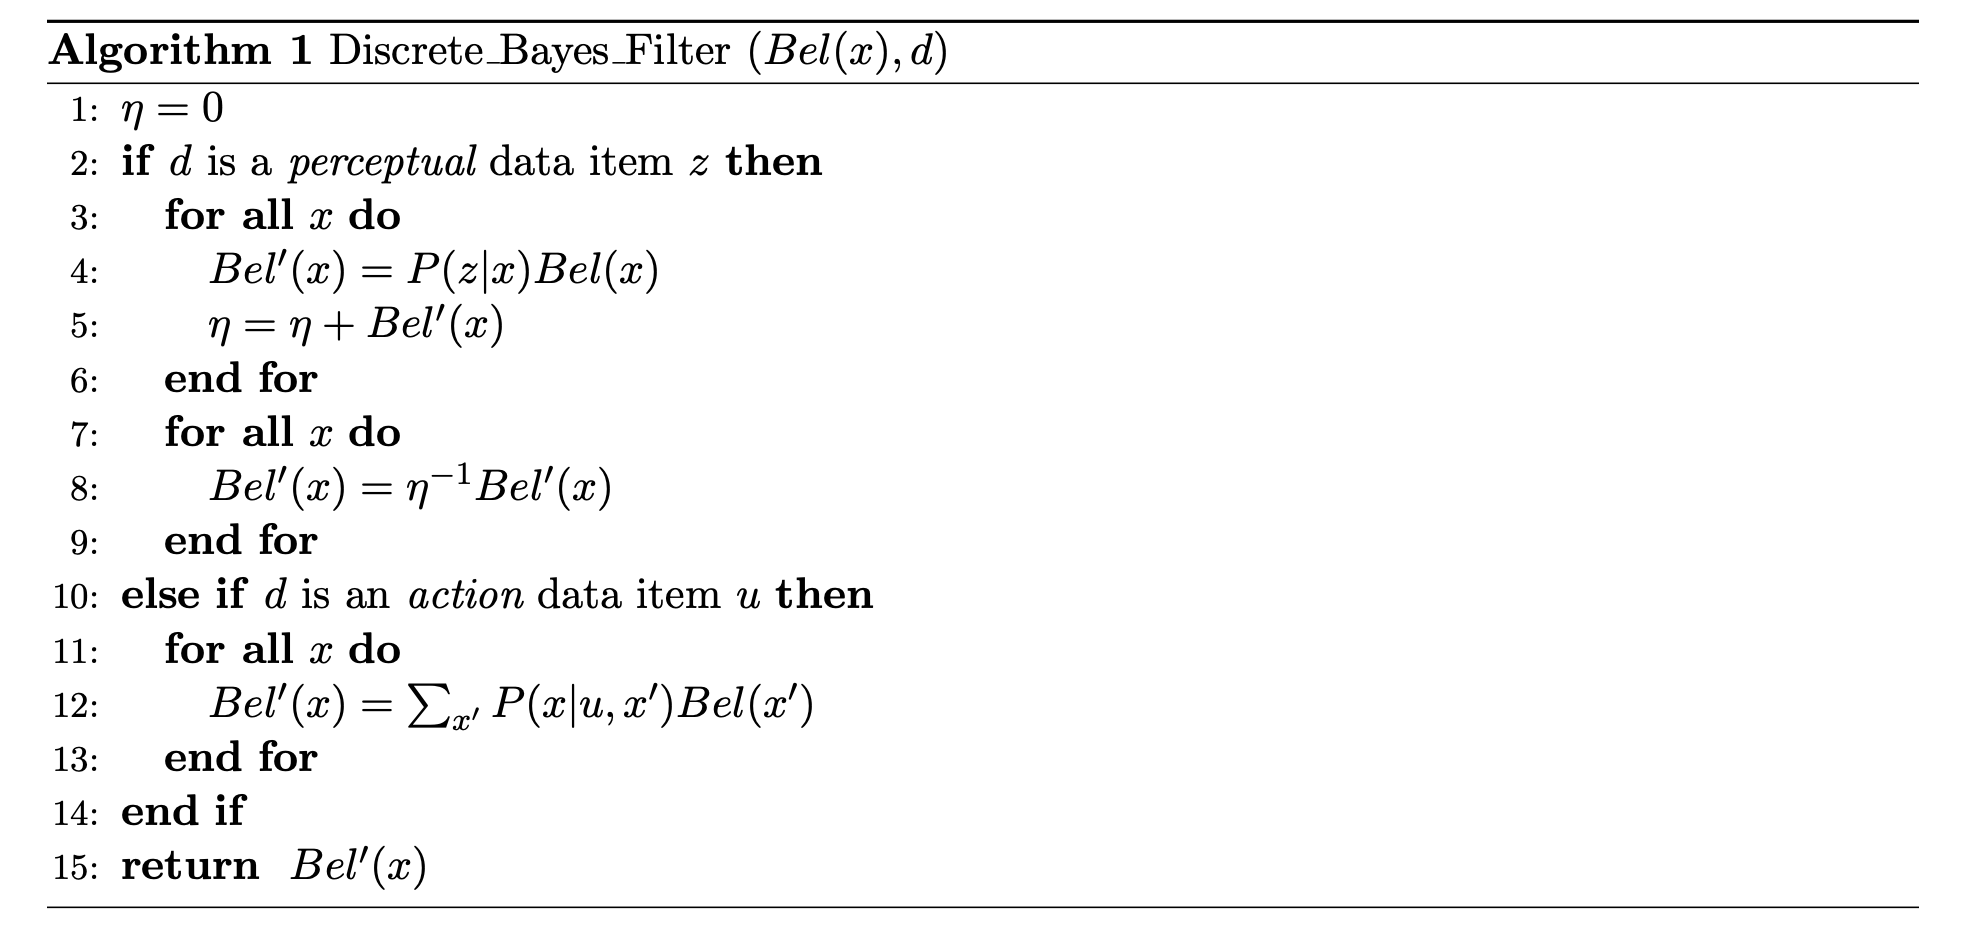

## Initializing Beliefs: The Notion of a Prior

How should we initialize our beliefs $Bel(x)$, in the absence of any data? How should we compute $\{Bel'(x) \ | \ x \in \mathcal{X}\}$ in our first update?

The choice of initialization for beliefs is referred to as a [*prior*](https://en.wikipedia.org/wiki/Prior_probability), and reflects our initial "guess" for the localization of the robot.

The choice of a prior is an important one; to see that this is true, consider just how differently the updates described above might evolve if we intialize $Bel(x)$ to each of $\{0, \ 1/|\mathcal{X}|, \ 1\}$.

## Bayes Filter Updates

Now that we are familiar with the form of the Bayes Filter update equation, we turn towards answering the important point left unresolved by this algorithm: **just how should we go about estimating the conditional probabilities $\mathbb{P}(z \ | \ x), \mathbb{P}(x \ | u, x')$?**

This is where [Kalman Filters](https://en.wikipedia.org/wiki/Kalman_filter) and [Particle Filters](https://en.wikipedia.org/wiki/Particle_filter) come in.

In Kalman filtering, we assume that state variables under sensor uncertainty are *normally distributed*. In other words, our beliefs of the robot's localization over the possible state space $\mathcal{X}$ can be described via a Gaussian distribution, $Bel(x \in \mathcal{X}) \sim \mathcal{N}(\mu, \Sigma)$ centered on some state $\mu$, with uncertainty (e.g. due to sensor or dynamics noise) modeled by the covariance matrix $\Sigma$. You can learn more about Kalman Filtering [here](https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/).

In particle filtering, we break away from the Gaussian/normal distribution model and instead use a set of *particles* or *samples* to represent our beliefs. Each particle or sample has a *likelihood weight* assigned to it that represents the probability of that particle being sampled the probability density function.

## 1-D Kalman Filter: Localizing a Dog in a Hallway

In this section, we'll work through a simple example of 1-D Kalman filtering used in practice. The code below is adapted from Roger Labbe's Kalman filtering textbook [available here](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python).

Suppose that during a recent hackathon held at NYU, a team of CS undergraduate students built a cost-effective (but noisy!) RFID tracker. The students would like to test this tracker by using it to localize the position of a professor's dog as it walks through a hallway in the CDS building.

The sensor returns the distance of the dog from the left end of the hallway in meters.

As mentioned earlier, however, the sensor is noisy! A reading of 23.4 could correspind to the dog being at 23.2 or 23.9 meters from the left end of the hallway.

The sensor was designed to be reasonably accurate, with errors that are small and evenly distributed on both sides of the true position, so that sensor errors are well-modeled by a Gaussian distribution.

We will model our belief in the dog's position with a Gaussian distribution.

In [1]:
! pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110473 sha256=b1100fe540fdbd1e2799b8f645d861fb08ba5e5c6d889a21de690749878fdc60
  Stored in directory: /root/.cache/pip/wheels/53/e6/de/a09ea01e923aaf88b9f8c7c44329e857b2c1a31901167e55e6
Successfully built filterpy


In [2]:
"""Copyright 2015 Roger R Labbe Jr.
Code supporting the book
Kalman and Bayesian Filters in Python
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
This is licensed under an MIT license. See the LICENSE.txt file
for more information.
"""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import copy
import math
import numpy as np
from numpy.random import randn

class DogSimulation(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0, process_var=0.0):
        """ x0 - initial position
            velocity - (+=right, -=left)
            measurement_variance - variance in measurement m^2
            process_variance - variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.measurement_noise = math.sqrt(measurement_var)
        self.process_noise = math.sqrt(process_var)


    def move(self, dt=1.0):
        '''Compute new position of the dog assuming `dt` seconds have
        passed since the last update.'''
        # compute new position based on velocity. Add in some
        # process noise
        velocity = self.velocity + randn() * self.process_noise * dt
        self.x += velocity * dt


    def sense_position(self):
        # simulate measuring the position with noise
        return self.x + randn() * self.measurement_noise


    def move_and_sense(self, dt=1.0):
        self.move(dt)
        x = copy.deepcopy(self.x)
        return x, self.sense_position()


    def run_simulation(self, dt=1, count=1):
        """ simulate the dog moving over a period of time.
        **Returns**
        data : np.array[float, float]
            2D array, first column contains actual position of dog,
            second column contains the measurement of that position
        """
        return np.array([self.move_and_sense(dt) for i in range(count)])


In [3]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

In [4]:
def update(prior, measurement):
    '''
    Kalman Update Function
    '''
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    '''
    Kalman Prediction Function
    '''
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

In [5]:
process_var = 2. # variance in the dog's movement
sensor_var = 4.5 # variance in the sensor
x = gaussian(0., 400.) # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity * dt, process_var)  # displacement to add to x
N = 25 # number of timesteps

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [np.array(dog.move_and_sense()) for _ in range(N)]

xs, beliefs, vars = np.zeros((N, 2)), np.zeros((N, 2)),  np.zeros((N, 1))
for i, z in enumerate(zs):
    belief = predict(x, process_model)    
    x = update(belief, gaussian(z, sensor_var))
    beliefs[i] = belief.mean
    xs[i] = x.mean
    vars[i] = x.var

For each iteration of the Kalman filter variant of the Bayes filter loop, we form a belief, take a measurement, form a likelihood from the measurement, and then incorporate the likelihood into the belief.

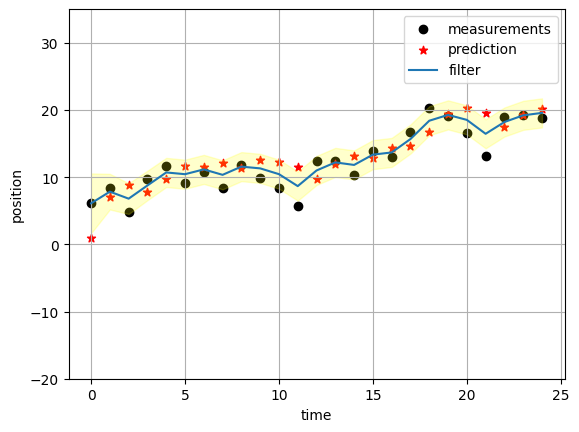

In [6]:
import matplotlib.pyplot as plt


zs = np.array(zs)

fig, ax = plt.subplots()
ax.grid()
ax.set_ylim(-20, 35)
ax.scatter(np.arange(25), zs[:, 1], label='measurements', color='k', marker='o')
ax.scatter(np.arange(25), beliefs[:, 1],  marker='*', color='r', label='prediction')
ax.fill_between(np.arange(25), xs[:, 1] - vars.flatten(), xs[:, 1] + vars.flatten(), color='yellow', alpha=0.2)
ax.plot(np.arange(25), xs[:, 1], label='filter')
ax.set_xlabel('time')
ax.set_ylabel('position')
ax.legend()